In [1]:
using CellBasedModels 
using CairoMakie
using GeometryBasics

In [2]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :tTumble=>Float64,
        ),    #Local Interaction Parameters

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64,
            :ωTumble=>Float64,
            :τTumble=>Float64,
            :fChem=>Float64,
            :active=>Bool,
            :ωMedium=>Float64
        ),        #Global parameters

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta)
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta)
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    agentRule = quote
        if tTumble < t && active
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((1-mm)*τTumble)
        end

        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end

        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end

    end,

    mediumODE=quote 
        if @mediumInside()
            dt(mm) = @∂2(1,mm)
        elseif @mediumBorder(1,-1)
            mm = 0
        elseif @mediumBorder(1,1)
            mm = max(cos(ωMedium*t),0.)
        elseif @mediumBorder(2,-1)
            mm = 0
        elseif @mediumBorder(2,-1)
            mm = 0
        end
    end

);


In [3]:
com = Community(
                rods2DChemotaxis,
                N=1,
                dt=0.1,
                simBox=[-10 10;-10 10.],
                NMedium=[100,100]
            )

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 1
com.τTumble = 2
com.ωTumble = 1
com.ωMedium = 1

com.m = 1.        
com.d = 1.        
com.l = 2.99;

2.99

In [4]:
evolve!(com,steps=100)

In [ ]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])

heatmap!(ax,
        range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
        range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
        com.mm,
        colorrange=(0,1.)
    )
lines!(ax,[i[1] for i in d[:x]],[i[1] for i in d[:y]])

xlims!(com.simBox[1,:]...)
ylims!(com.simBox[2,:]...)

Colorbar(fig[1,2],)

display(fig)

In [59]:
function plotRods2D!(ax, x, y, d, l, angle, color)

    meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0),Float32(1)),
                color = color
            )
    meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0),Float32(1)),
                color = color
            )
    # meshscatter!(ax,
    #             x.+l./2 .*cos.(angle),
    #             y.+l./2 .*sin.(angle),
    #             marker=GeometryBasics.Cylinder(Point3f(0,0,0),Point3f(1,0,0),Float32(1)),
    #             markersize=[Point3f(ll,0,dd) for (ll,dd) in zip(l,d)],
    #             angle=angle,
    #             color = color
    #         )

    return

end

plotRods2D! (generic function with 1 method)

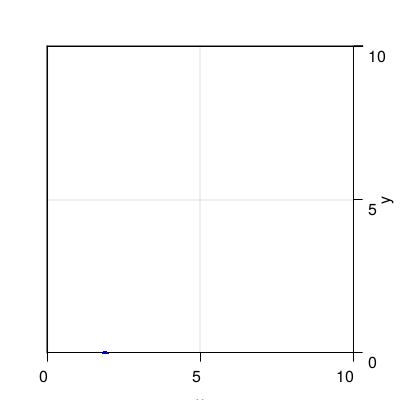

In [60]:
fig = Figure(resolution=(400,400))
ax = Axis3(fig[1,1],
            azimuth=3*π/2,
            elevation=π/2,
            zlabelvisible=false,
            zticklabelsvisible=false,
            zgridvisible=false, 
            zspinesvisible=false
        )

plotRods2D!(ax,com.x,com.y,com.d,com.l,com.theta,[:blue])

xlims!(0,10)
ylims!(0,10)

display(fig)